# Tesis GBM: Dynamics of Bargaining Power
# Multi Objective Static Model (weighted sum) - Continuous Actions
# (MOSPA)

#### Genaro Basulto Mejía
#### 2022 

This code was made specifically to solve the static multi-objective principal-agent model with continuous actions.  

This aplication uses the JuMP library and the Ipopt solver to solve the optimization problrem given a value for the bargaining power.

The use uf this library allows us to easily change the parametrization of the problem and rely on a robust solver to find solutions in multi-criteria non-linear restricted optimization problems. 

## Libraries

In [4]:
using DataFrames
using XLSX 
using JuMP # Loading optimization libraries.
using Ipopt # Ipopt solves a nonlinear optimization problem.
using ExcelFiles  # Loading excel files libraries.

## Utility Functions and Probability Functions

In [5]:
#v(c,a,g=1,alpha=1)=-exp(g*(a-alpha*c))  # Declaration of v (agent utility function); 
                                        # g is the coefficient of risk aversion
                                        # alpha is a cost coefficientv

v(c, h=0.50) =  (c^(1-h))/(1-h) #CRA Function 
                                    #h is a oefficient of risk aversion
                                    # a is the agent effort

u(y,w)=y-w  #Declaration of the principal utility function 
            #y is the current output
            #w is the salary paid to the agent

paretopdf(a,L,H,x) = (a*(L^a)*(x^(-a-1)))/(1-(L/H)^a)
paretocdf(a,L,H,x) = (((L/x)^a)*log(x/L)*(1-(L/H)^a)-((L/H)^a)*log(H/L)*(1-(L/x)^a))/((1-(L/H)^a)^2)
#(1-(L/x)^(a))/(1-(L/H)^a)

paretocdf (generic function with 1 method)

## Variables and Lists

In [6]:
Y = [0.4 0.8]    # Outcomes set [yl yh]
h = 0.5 #Parameter for agent utility 
beta = 0.96 #Temporal Discount Factor
n = 101 #Number of intervals for the bargaining power
Deltas = LinRange(0.02,0.4,n) #List of bargaining powers
a_min = 0.1

0.1

## Model Specification 

In [7]:
function Solve_Model(h, delta, start_xl = Y[1]/2, start_xh = Y[2]/2, L=Y[1], H=Y[2], x = (Y[1]+Y[2])/2)
    """
    This functions declares and solves the model for the weighted sum of agent and principal utilities 
    Returns optimal values if found 
    """
    model = Model(
            with_optimizer(
                Ipopt.Optimizer, 
                tol = 1e-7, 
                max_iter = 1000,
                print_level=0)) 

    # Declare the decision variables for the model: xl = wl, xh = wh.
    @variable(model, xl >= 0.00001, start = start_xl)  # xl = wl, low compensation.
    @variable(model, xh >= 0.00001, start = start_xh)  # xh = wh, hight compensation.
    @variable(model, a >= a_min, start = 1)  # Optimal action 
    #Agregar una cota superior a las acciones!

    # Declare the agent's utility function within the model.
    register(model, :v, 2, v, autodiff=true)    # m, the model name
                                            # :v,  **********                                          
                                            # 2, number of variables
                                            # v, declare the agent's utility function 
                                            # autodiff,    **********
    register(model, :u, 2, u, autodiff=true) 
    register(model, :paretocdf, 4, paretocdf, autodiff=true) 
    register(model, :paretopdf, 4, paretopdf, autodiff=true)  
    # Non-linear type expressions are declared, the expected utility of the agent, within the model. 
    EV = @NLexpression(model, paretocdf(a,L,H,x)*v(xh,h)+(1-paretocdf(a,L,H,x))*v(xl,h)-a)  # E(v|ah)
    EU = @NLexpression(model, paretocdf(a,L,H,x)*u(Y[2],xh)+(1- paretocdf(a,L,H,x))*u(Y[1],xl)) #E(U|ah)

    # Objective function; expected utility of the principal and the agent given ah.
    @NLobjective(model, Max, delta*EV+(1-delta)*EU) 

    @constraint(model, xh<=Y[2])  # Financial capacity restriction for high compensation; wh<=yh.
    @constraint(model, xl<=Y[1])  # Financial capacity restriction for low compensation; wl<=yl.
    @NLconstraint(model,  paretopdf(a,L,H,x)*(v(xh,h)-v(xl,h))- 1 == 0) 
    
    # The problem for incentive ah is solved.
    JuMP.optimize!(model) 

    #The optimal values are saved and returned
    wh = value(xh)
    wl = value(xl)
    a_opt = value(a)
    u_opt = paretocdf(a_opt,L,H,x)*u(Y[2],wh)+(1- paretocdf(a_opt,L,H,x))*u(Y[1],wl)
    v_opt = paretocdf(a_opt,L,H,x)*v(wh,h)+(1-paretocdf(a_opt,L,H,x))*v(wl,h)-a_opt
    return u_opt, v_opt, wl, wh, a_opt, termination_status(model)
end

Solve_Model (generic function with 6 methods)

## Routine 

In [8]:
function Static_Pareto_Frontier(Deltas, n, h)
    """
    This functions finds the pareto frontier for the Multi Objective Static Model  
    Returns optimal values if found 
    """
    u_val = 0 #Initialization of the principal utility for the current bargaining power
    v_val = 0 #Initialization of the agent utility for the current bargaining power
    U= [] #List of principal Utilities
    V= [] #List of agent utilities
    Acc_opt= [] #List of reccomended actions
    a = 0 #Initialization of the principal utility for the current bargaining power
    comp_opt = (0,0) #Tuple of compensations (wh,wl)
    Comp = [] #List of compensations
    for delta in Deltas #loop for bargaining power
        val = -100 #Initialization of the weighted sum of the agent and pricial's utilities for the current bargaining power

        #Solve the model for high effort given the current bargaining power
        u_opt, v_opt, xl, xh, acopt, stat = Solve_Model(h, delta) 
        #If the weighted sum of utilities is higher than it's last value
        if (delta*v_opt+(1-delta)*u_opt>val) & (stat == MOI.LOCALLY_SOLVED) 
            val = delta*v_opt+(1-delta)*u_opt #Update sum of utilities 
            u_val=u_opt #Update optimal value for the princial utility
            v_val = v_opt #Update optimal value for the agent utility
            comp_opt=(xl,xh) #Update optimal value for the compensation 
            a= acopt #Udate optimal reccomended action                       
        end
        print("Delta= ", delta, "  u=", u_val, "  Acc= ", a, "\n")
         #Save all optimal values for the current bargaining power
        append!(U, u_val/(1-beta))
        append!(V, v_val/(1-beta))
        append!(Acc_opt, a)
        push!(Comp, comp_opt)

    end

    #Save result of all variables in dataframe 
    Data_Weighted_Sum = DataFrame(
        Recomended_Action = Acc_opt,
        Delta = Deltas,
        Agent_Utility = V,
        Principal_Utility = U,
        High_Compensation = [comp[2] for comp in Comp],
        Low_Compensation = [comp[1] for comp in Comp])
    return Data_Weighted_Sum
end

Static_Pareto_Frontier (generic function with 1 method)

## Execution of the Routine.

In [9]:
Data_Weighted_Sum = Static_Pareto_Frontier(Deltas, n, h)

save("Continuous_Actions/ModEst_y0408_h05.xlsx", Data_Weighted_Sum) #Save to excel file


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Delta= 0.02  u=0.42972651929973227  Acc= 0.1
Delta= 0.0238  u=0.42956021193453064  Acc= 0.1
Delta= 0.0276  u=0.4293489927204288  Acc= 0.1
Delta= 0.0314  u=0.4291036870037469  Acc= 0.1
Delta= 0.035199999999999995  u=0.4288235070557009  Acc= 0.1
Delta= 0.03900000000000001  u=0.4285076478450113  Acc= 0.1
Delta= 0.042800000000000005  u=0.42815528684073656  Acc= 0.1
Delta= 0.0466  u=0.42776557945870325  Acc= 0.1
Delta= 0.0504  u=0.42733765235573756  Acc= 0.1
Delta= 0.0542  u=0.4268706332728236  Acc= 0.1
Delta= 0.05800000000000001  u=0.4263636056351864  Acc= 0.1
Delta= 0.06180000000000001  u=0.4258156446396051  

### Plotting 

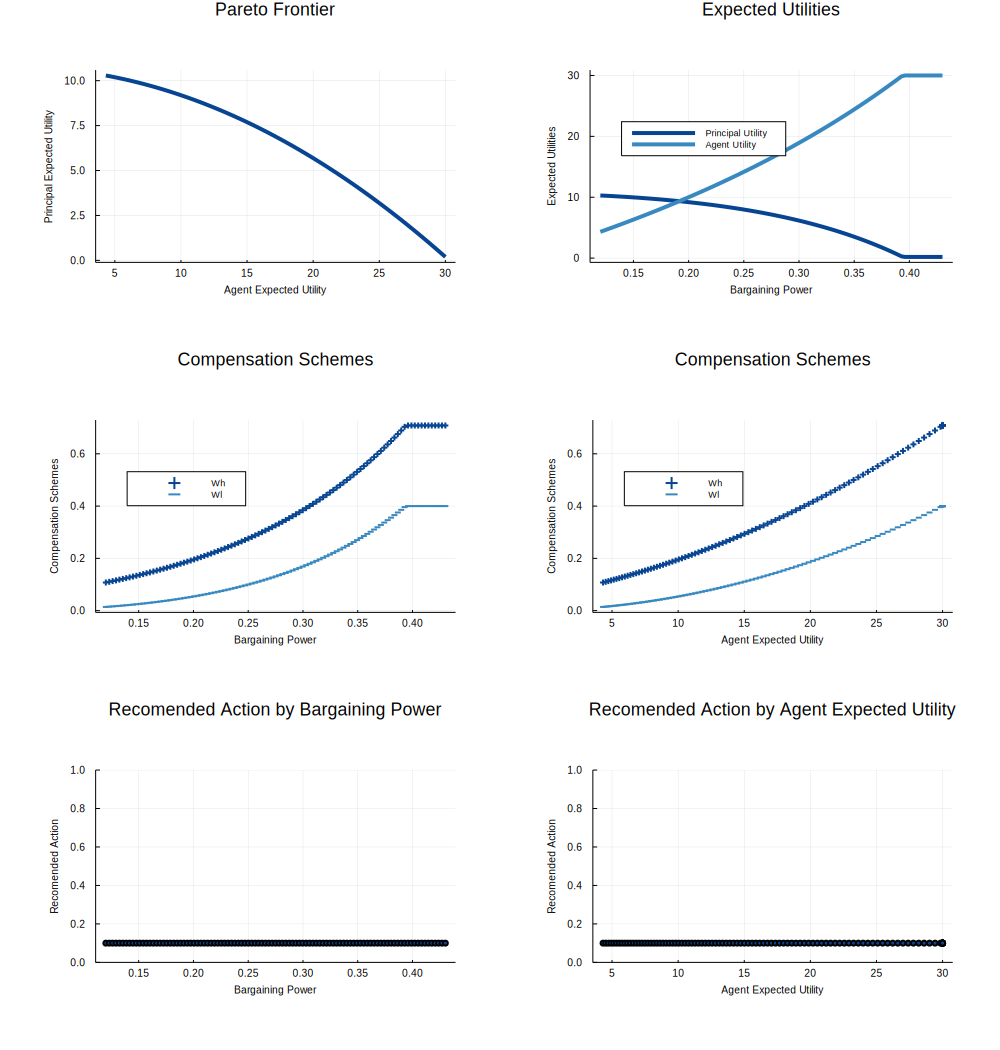

In [17]:
using Plots, Plots.PlotMeasures    # Plots packages load
using Colors, ColorSchemes

theme(:default)     # Graphics theme
p = get(ColorSchemes.Blues_8, [1.25 - i/4 for i in 1:4])

#Recomended Action by bargaining power plot.
pl1=scatter(Data_Weighted_Sum[:,"Delta"], Data_Weighted_Sum[:,"Recomended_Action"], 
    legend = false,
    title = "Recomended Action by Bargaining Power", 
    xlabel = "Bargaining Power",ylims = (0,1),
    ylabel =  "Recomended Action", palette = p)

#Pareto Frontier Plot 
pl2=plot(Data_Weighted_Sum[:,"Agent_Utility"], Data_Weighted_Sum[:,"Principal_Utility"],
    legend = false,
    title = "Pareto Frontier", 
    xlabel = "Agent Expected Utility",
    ylabel =  "Principal Expected Utility", palette = p, lw = 4) 

#Compensation Schemes by bargaining power plot. 
pl3=scatter([Data_Weighted_Sum[:,"Delta"], Data_Weighted_Sum[:,"Delta"]], [Data_Weighted_Sum[:,"High_Compensation"], Data_Weighted_Sum[:,"Low_Compensation"]],
    shape = [:+ :hline :utri],
    labels = ["Wh" "Wl"],
    legend = :topleft,
    title = "Compensation Schemes", 
    xlabel = "Bargaining Power",
    ylabel =  "Compensation Schemes", palette = p)

#Compensation Schemes by agent utility plot
pl4=scatter([Data_Weighted_Sum[:, "Agent_Utility"], Data_Weighted_Sum[:, "Agent_Utility"]], [Data_Weighted_Sum[:, "High_Compensation"], Data_Weighted_Sum[:, "Low_Compensation"]],
    shape = [:+ :hline :utri],
    labels = ["Wh" "Wl"],
    legend = :topleft,
    title = "Compensation Schemes", 
    xlabel = "Agent Expected Utility",
    ylabel =  "Compensation Schemes", palette = p)

#Expected Agent and Principal utilities plot. 
pl5=plot([Data_Weighted_Sum[:,"Delta"], Data_Weighted_Sum[:,"Delta"]], [Data_Weighted_Sum[:, "Principal_Utility"], Data_Weighted_Sum[:, "Agent_Utility"]],
    labels = ["Principal Utility" "Agent Utility"],
    legend = :topleft,
    title = "Expected Utilities", 
    xlabel = "Bargaining Power",
    ylabel =  "Expected Utilities", palette = p, lw = 4) 

#Recomended Action by agent expected utility plot.
pl6=scatter(Data_Weighted_Sum[:, "Agent_Utility"], Data_Weighted_Sum[:, "Recomended_Action"],
    legend = false,
    title = "Recomended Action by Agent Expected Utility", 
    xlabel = "Agent Expected Utility",
    ylabel =  "Recomended Action", 
    ylims = (0,1),
    palette = p)

#layout
l = @layout [a b ; c d; e f]

#figure
complete_plot = plot(pl2, pl5, pl3, pl4, pl1, pl6, layout = l,
    size = (1000,1050),
 #   dpi = 1000,
    xtickfont = font(7), 
    ytickfont = font(7), 
    guidefont = font(7), 
    titlefont = font(12),
    legendfont = font(6),
    markersize = 3,
    margin = 10mm) 
display(complete_plot)
#Save figure
#savefig("Continuous_Actions/CRA_fdp_exp_h05")